    
#  CNN Data Augmentation


- Data가 많지 않아 CNN 학습에 어려움이 있을 때 사용 가능한 방법
    - Data augmentation 활용
        - 이미지의 색깔, 각도 등을 약간씩 변형하여 data의 수를 늘림 
    - Pre-trained network의 활용
        - 대용량 데이터를 이용해 학습된 기존의 모델과 weight를 불러온 후 목적에 맞게 약간 수정하여 학습

### Loading data

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_dataset = h5py.File('data/train_signs.h5', "r")

X_train_org = np.array(train_dataset["train_set_x"]) 
y_train_org = np.array(train_dataset["train_set_y"]) 

test_dataset = h5py.File('data/test_signs.h5', "r")
X_test_org = np.array(test_dataset["test_set_x"]) 
y_test_org = np.array(test_dataset["test_set_y"]) 

classes = np.array(test_dataset["list_classes"]) 

In [3]:
print(X_train_org.shape, y_train_org.shape)
print(X_test_org.shape, y_test_org.shape)

(1080, 64, 64, 3) (1080,)
(120, 64, 64, 3) (120,)


5


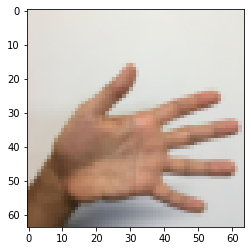

In [4]:
index = 0
plt.imshow(X_train_org[index])
print(y_train_org[index])

### 데이터 준비

- train set을 train/validation set으로 나눔
    - 200개를 validation, 나머지 훈련 데이터셋으로 나누기.
- target label을 one-hot encoding으로 변환   

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_validation, y_train_tmp, y_validation_tmp=train_test_split(X_train_org, y_train_org, 
                                                                      stratify=y_train_org, 
                                                                      test_size=200)  # test size: 테스트셋 분리 비율 기본 0.25, 정수값으로 설정하면 개수로 나눔  

In [7]:
X_train.shape, X_validation.shape, y_train_tmp.shape, y_validation_tmp.shape

((880, 64, 64, 3), (200, 64, 64, 3), (880,), (200,))

#### y 원핫인코딩

In [8]:
from tensorflow.keras.utils import to_categorical
y_train=to_categorical(y_train_tmp)
y_validation=to_categorical(y_validation_tmp)

In [9]:
y_train.shape

(880, 6)

In [10]:
y_train[0], y_train_tmp[0]

(array([0., 0., 0., 1., 0., 0.], dtype=float32), 3)

### 모델 생성
- 모델을 생성하고 complile한 뒤 반환하는 함수 만들기

In [11]:
from tensorflow.keras import models, layers
from tensorflow.keras import optimizers

In [12]:
def build_model(learning_rate=0.00001, dropout_rate=0.5):
    model=models.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3), padding='same'))
    model.add(layers.MaxPooling2D((2,2)))
    
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(dropout_rate))  # 과소적합인경우 dropout값을 낮춘다.
    model.add(layers.Dense(64, activation='relu'))
    
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(64, activation='relu'))
    
    model.add(layers.Dense(6, activation='softmax'))
    
    model.compile(optimizer=optimizers.Adam(lr=learning_rate),  # optimizers:패키지. 매개변수에 따라 learning_rate가 바뀐다.
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
        
                  
    return model

In [13]:
model=build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dropout (Dropout)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

## generator함수

In [14]:
# generator
def my_generator(num):
    for i in range(num):
        yield i  # return은 한번 값을 호출하고 함수가 끝나지만,
# yield는 값을 호출 한 뒤에도 함수를 기억하고 다음 실행때 이어서 돌아간다. 단, 변수명을 설정하고 next와 함께 사용

In [15]:
g=my_generator(10)
next(g)

0

In [16]:
next(g)

1

In [17]:
for i in my_generator(5):
    print(i)

0
1
2
3
4


In [18]:
for i in [0,1,2,3,4]:
    print(i)

0
1
2
3
4


# Image Augmentation
- 훈련시킬 이미지 데이터셋이 부족할 경우 기존 이미지를 조금씩 변환시켜 이미지 데이터 양을 늘린다.

## ImageDataGenerator를 이용
- 이미지를 전처리해서 제공하는 generator 생성해 주는 클래스
    - next() 로 호출 될 때 마다 설정대로 변환/전처리된 이미지를 계속 제공하여 하나의 이미지를 여러개로 늘릴 수있다.
- 생성자의 매개변수로 이미지를 어떻게 전처리/변환 할지 지정해 준다.
- flow() 메소드를 이용해 generator를 생성한다.
- 주요 변환속성
    - **rescale**: scaling값. image 배열의 원소에 지정한 값을 곱한다.
    - **rotation_range**: 0 ~ 지정된 각도 범위내에서 임의로 원본이미지를 회전 (ex: ratation_range = 20 => 0 ~20 도 범위로 회전)
    - **width_shift_range**: 지정한 범위내에서 수평 방향으로 원본이미지를 이동. 실수로 지정. (ex: width_shift_range = 0.1  전체 너비의 0.1 범위로 수평이동. 전체 너비가 100이면 10픽셀 이하로 좌우 이동)
    - **height_shift_range**: 지정한 범위내에서 수직 방향으로 원본이미지를 이동. 실수로 지정.
    - **zoom_range**: 지정된 범위 내에서 원본이미지를 확대/축소. 1-지정한 수치 ~ 1 + 지정한수치 범위로 확대 축소한다.
    - **horizontal_flip**: True. 좌우방향으로 뒤집는다.
    - **vertical_flip** : True. 아래위방향으로 뒤집는다.
- Generator 생성 메소드
    - **flow()** : 변환된 이미지 배치를 제공하는 generator 생성
        - x: 변환할 이미지 배열. rank 4의 ndarray나 tuple.
        - y: 이미지 라벨 배열
        - batch_size: 학습시 모델에 한번에 제공할 이미지 개수
    - **flow_from_directory()**: 디렉토리를 받아 그 안의 이미지들을 변환해 제공하는 generator 생성
        - directory: 이미지 저장 (이미지는 지정한 디렉토리내에 클래스 별로 디렉토리가 나눠져 저장되 있어야 한다. 오름차순으로 번호가 붙는다.),
        - target_size : 이미지 resize 크기. 기본값 (256, 256)
        - color_mode: 이미지 모드 ('grayscale','rgb'(기본값), 'rgba')
        - class_mode: image의 label 형식. 'binary', 'categorical'. 
        - batch_size: 배치사이즈
- **모델에서 학습시 fit_generator()함수 사용. X, y 대신 ImageGenerator객체를 사용한다.**   
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator?version=stable

In [19]:
from tensorflow.keras.preprocessing import image

In [20]:
img_gen=image.ImageDataGenerator(rescale=1/255,
                                rotation_range=25,  # 0도~25도 사이로 회전
                                width_shift_range=0.1,  # 전체픽셀의 0~10% 만큼 좌우로 이동
                                height_shift_range=0.1,  # 전체픽셀의 0~10% 만큼 상하로 이동
                                zoom_range=0.2,  # 0.8~1.2만큼 축소 확대 (원본사이즈:1)
                                horizontal_flip=True,
                                vertical_flip=True)

In [21]:
sample_img=X_train[0]

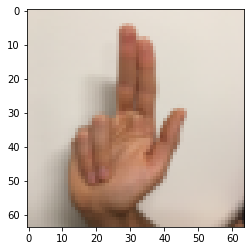

In [22]:
plt.imshow(sample_img)

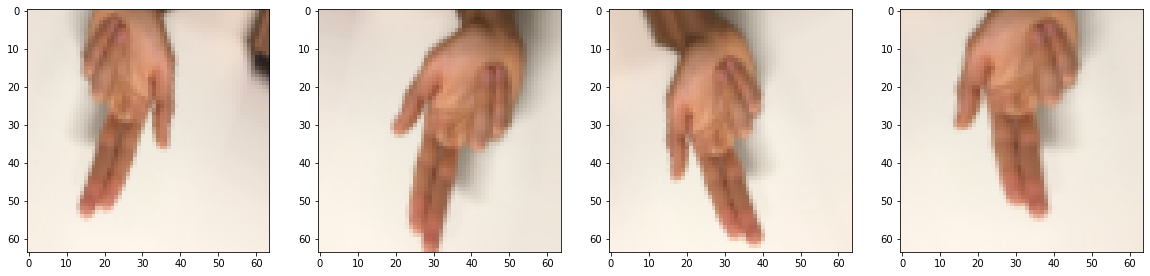

In [23]:
max_iter=4
cnt=1
sample_img2=sample_img[np.newaxis,...] # (개수, h, w, channel)
plt.figure(figsize=(20,10), facecolor='w')
for batch in img_gen.flow(sample_img2):
    plt.subplot(1, max_iter, cnt)
    plt.imshow(image.array_to_img(batch[0]))
    if cnt==max_iter:
        break
    cnt+=1

## train, validate generator 생성

In [24]:
train_generator=img_gen.flow(X_train, y_train, batch_size=32)
validation_generator=img_gen.flow(X_validation, y_validation, batch_size=50)

In [25]:
next(validation_generator)[0].shape

(50, 64, 64, 3)

## Model fitting
- **train_generator**를 사용하여 모델을 훈련할 때는 **model.fit()** 대신 **model.fit_generator()**를 사용 
- 훈련 데이터셋을 대신 (input, target)을 끝없이 반환하는 generator를 첫 argument로 입력
- **매개변수**
    - **steps_per_epoch**: 한 epoch에서 generator로 부터 몇번 데이터셋을 요청할지 횟수. 지정한 개수당 gradient update(가중치 최적화)를 실행한다.
    - `model.fit_generator`를 사용할 때는 훈련데이터가 끝없이 생성되기 때문에 다음 epoch로 넘어가기 전에 몇 번의 gradient update를 시행해 줄 것인지를 명시함
        - 1 에폭에서 사용하는 훈련데이터셋의 수는 `generator의 batch_size * steps_per_epoch`. 
        - ex)generator의 batch_size가 20이고 steps_per_epoch이 50이면 한 epoch에서 사용하는 이미지(변환된) 수는 50 X 20
    - **validation_data**: 검증데이터셋 지정. validation_generator나  `(x_val, y_val)`과 같이 tuple 형태의 validation data를 지정.
    - **validation_steps**: `validation_data`에 generator를 지정했을 때만 사용하며 몇 번의 data generation을 통해 validataion data를 만들어 낼 것인가를 결정. 
        - `generator의 batch_size * validation_step`이 1 에폭당 검증데이터크기가 된다. 
        - 일반적으로 원하는 validation data 개수를 batch_size로 나눈 값으로 지정

In [26]:
model=build_model(0.01, 0.3)

In [27]:
# fit_generator()로 학습
model.fit_generator(train_generator,  # train_generator에 X, y이 모두 있으므로
                    steps_per_epoch=20,
                    epochs=5,
                    validation_data=validation_generator,
                    validation_steps=4)

Epoch 1/5
20/20 [==============================] - 5s 234ms/step - loss: 2.2851 - accuracy: 0.1651 - val_loss: 1.7939 - val_accuracy: 0.1650
Epoch 2/5
20/20 [==============================] - 4s 222ms/step - loss: 1.7964 - accuracy: 0.1547 - val_loss: 1.7924 - val_accuracy: 0.1650
Epoch 3/5
20/20 [==============================] - 6s 297ms/step - loss: 1.7927 - accuracy: 0.1667 - val_loss: 1.7925 - val_accuracy: 0.1650
Epoch 4/5
20/20 [==============================] - 6s 304ms/step - loss: 1.7926 - accuracy: 0.1587 - val_loss: 1.7920 - val_accuracy: 0.1650
Epoch 5/5
20/20 [==============================] - 6s 283ms/step - loss: 1.7936 - accuracy: 0.1410 - val_loss: 1.7919 - val_accuracy: 0.1700


## 모델 평가


In [28]:
y_test=to_categorical(y_test_org)
test_loss, test_acc=model.evaluate(X_test_org/255, y_test)

120/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [29]:
test_loss, test_acc

(1.791983183224996, 0.16666667)

In [31]:
img_gen2=image.ImageDataGenerator(rescale=1/255)

In [32]:
test_generator=img_gen2.flow(X_test_org, y_test, batch_size=64)

In [33]:
model.evaluate_generator(test_generator, steps=10)

[1.7920071840286256, 0.16666667]